In [1]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline
# plt.style.use("ggplot")
sns.set_style("darkgrid")

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
data = pd.read_csv("final_10minutes.csv")
data.drop(['Month'], axis =1, inplace= True)
#data.set_index("time", inplace= True)
num_pickups = data.total
num_green_pickups = data.green
num_yellow_pickups = data.yellow
data.drop(['Unnamed: 0',  'green', 'yellow', 'total'], axis =1, inplace = True)

In [3]:
def series_to_supervised(data, n_in, n_out, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    agg = pd.concat(cols, axis = 1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace = True)
        
    return agg

In [4]:
#normalize data & make LSTM model structure
features_and_target = pd.concat([data, num_pickups], axis = 1)
values = features_and_target.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range = (0, 1))
scaled = scaler.fit_transform(values)

n_hours = 47

reframed = series_to_supervised(scaled, n_hours, 1)

n_features = features_and_target.shape[1]


In [5]:
# exlcude significantly deviated data
total_values = reframed.values
n_p = np.argmin(total_values[365*24*3*6:, -1])
n_p = n_p + 365*24*3*6

a = total_values[: n_p, :]
b = total_values[n_p + n_hours + 6 + 1 : , :]
values = np.concatenate((a, b), axis=0)

In [6]:
# split into train and test sets 
n_train_hours = 365 * 24 * 3 * 6
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(157680, 235) 157680 (157680,)
(157680, 47, 5) (157680,) (39355, 47, 5) (39355,)


In [7]:
# design network
model = Sequential()
model.add(LSTM(24, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=100,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 157680 samples, validate on 39355 samples
Epoch 1/100
 - 42s - loss: 0.0291 - val_loss: 0.0126
Epoch 2/100
 - 41s - loss: 0.0145 - val_loss: 0.0098
Epoch 3/100
 - 42s - loss: 0.0129 - val_loss: 0.0097
Epoch 4/100
 - 43s - loss: 0.0118 - val_loss: 0.0093
Epoch 5/100
 - 41s - loss: 0.0114 - val_loss: 0.0093
Epoch 6/100
 - 42s - loss: 0.0111 - val_loss: 0.0093
Epoch 7/100
 - 41s - loss: 0.0109 - val_loss: 0.0089
Epoch 8/100
 - 43s - loss: 0.0107 - val_loss: 0.0093
Epoch 9/100
 - 42s - loss: 0.0105 - val_loss: 0.0088
Epoch 10/100
 - 41s - loss: 0.0102 - val_loss: 0.0096
Epoch 11/100
 - 42s - loss: 0.0103 - val_loss: 0.0093
Epoch 12/100
 - 44s - loss: 0.0101 - val_loss: 0.0091
Epoch 13/100
 - 41s - loss: 0.0099 - val_loss: 0.0088
Epoch 14/100
 - 42s - loss: 0.0099 - val_loss: 0.0093
Epoch 15/100
 - 44s - loss: 0.0098 - val_loss: 0.0093
Epoch 16/100
 - 41s - loss: 0.0098 - val_loss: 0.0093
Epoch 17/100
 - 41s - loss: 0.0097 - val_loss: 0.0096
Epoch 18/100
 - 39s - loss: 0.0096 - val

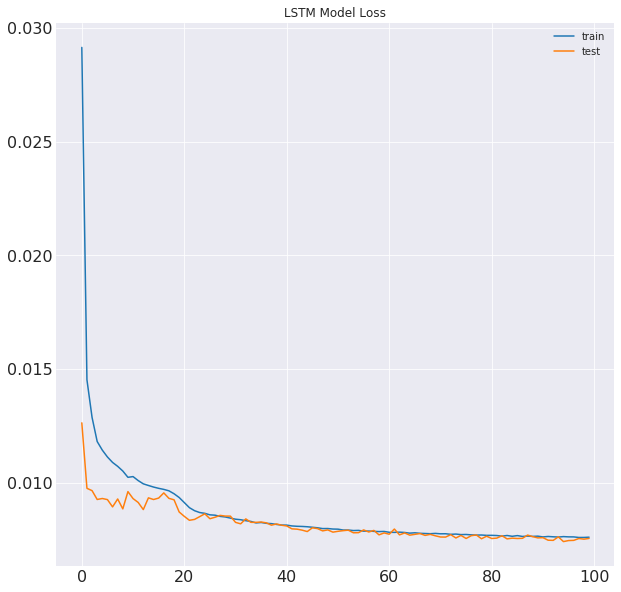

In [8]:
history_loss = pd.DataFrame()
history_loss['train'] = history.history['loss']
history_loss['test'] = history.history['val_loss']
history_loss.plot(figsize=(10,10), fontsize=16,
                title='LSTM Model Loss');

In [9]:
# make a prediction 
yhat = model.predict(test_X)
# reshape back to 2d
test_X = test_X.reshape((test_X.shape[0], -1))

# invert scaling for forecast# invert 
inv_yhat = np.concatenate((test[:, 235:239], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test[:, 235:239], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]
inv_yhat_gte_zero = inv_yhat.copy()
inv_yhat_gte_zero[inv_yhat_gte_zero < 0] = 0

# calculate r2
print("R2:  ", r2_score(inv_y, inv_yhat))

# calculate mean absolute error
print("MAE: ", mean_absolute_error(inv_y, inv_yhat))

# calculate rmse
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print("RMSE:", rmse)

# calculate mean absolute error percentage
maep = np.mean(np.abs((inv_y - inv_yhat)/inv_y))*100
print("mean absolute error percentage: ", maep)

R2:   0.9917217752103871
MAE:  72.51037
RMSE: 101.0424908686316
mean absolute error percentage:  3.747887909412384


In [10]:
error = np.abs((inv_y - inv_yhat)/inv_y)

In [11]:
worst1 = np.argmax(error)
worst1_val = np.max(error)
error = np.delete(error, worst1)
print(worst1, worst1_val)

10445 0.998805


In [12]:
worst2 = np.argmax(error)
worst2_val = np.max(error)
error = np.delete(error, worst2)
print(worst2, worst2_val)

96 0.6394991


In [13]:
worst3 = np.argmax(error)
worst3_val = np.max(error)
error = np.delete(error, worst3)
print(worst3, worst3_val)

10446 0.53875697


In [14]:
worst4 = np.argmax(error)
worst4_val = np.max(error)
error = np.delete(error, worst4)
print(worst4, worst4_val)

5271 0.53431416


In [15]:
worst5 = np.argmax(error)
worst5_val = np.max(error)
error = np.delete(error, worst5)
print(worst5, worst5_val)

8305 0.51947445


In [16]:
worst6 = np.argmax(error)
worst6_val = np.max(error)
error = np.delete(error, worst6)
print(worst6, worst6_val)

97 0.5057564


In [17]:
worst7 = np.argmax(error)
worst7_val = np.max(error)
error = np.delete(error, worst7)
print(worst7, worst7_val)

10440 0.5023154


In [18]:
worst8 = np.argmax(error)
worst8_val = np.max(error)
error = np.delete(error, worst8)
print(worst8, worst8_val)

10444 0.5022303


In [19]:
worst9 = np.argmax(error)
worst9_val = np.max(error)
error = np.delete(error, worst9)
print(worst9, worst9_val)

8306 0.49687505


In [20]:
worst10 = np.argmax(error)
worst10_val = np.max(error)
error = np.delete(error, worst10)
print(worst10, worst10_val)

34521 0.48999658


In [21]:
worst11 = np.argmax(error)
worst11_val = np.max(error)
error = np.delete(error, worst11)
print(worst11, worst11_val)

10432 0.47583744


In [22]:
worst12 = np.argmax(error)
worst12_val = np.max(error)
error = np.delete(error, worst12)
print(worst12, worst12_val)

10432 0.45203796


In [23]:
worst13 = np.argmax(error)
worst13_val = np.max(error)
error = np.delete(error, worst13)
print(worst13, worst13_val)

34309 0.45174634


In [24]:
worst14 = np.argmax(error)
worst14_val = np.max(error)
error = np.delete(error, worst14)
print(worst14, worst14_val)

10437 0.39103684


In [25]:
worst15 = np.argmax(error)
worst15_val = np.max(error)
error = np.delete(error, worst15)
print(worst15, worst15_val)

8306 0.38309148


In [26]:
worst16 = np.argmax(error)
worst16_val = np.max(error)
error = np.delete(error, worst16)
print(worst16, worst16_val)

37467 0.3825549


In [27]:
worst17 = np.argmax(error)
worst17_val = np.max(error)
error = np.delete(error, worst17)
print(worst17, worst17_val)

10431 0.3709054


In [28]:
worst18 = np.argmax(error)
worst18_val = np.max(error)
error = np.delete(error, worst18)
print(worst18, worst18_val)

26212 0.3670819


In [29]:
worst19 = np.argmax(error)
worst19_val = np.max(error)
error = np.delete(error, worst19)
print(worst19, worst19_val)

34305 0.3522231


In [30]:
worst20 = np.argmax(error)
worst20_val = np.max(error)
error = np.delete(error, worst20)
print(worst20, worst20_val)

10431 0.3405935
